In [26]:
!wget https://raw.githubusercontent.com/cbannard/lela60331_24-25/refs/heads/main/coursework/Compiled_Reviews.txt

--2025-01-27 16:19:03--  https://raw.githubusercontent.com/cbannard/lela60331_24-25/refs/heads/main/coursework/Compiled_Reviews.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22322605 (21M) [text/plain]
Saving to: ‘Compiled_Reviews.txt.1’

Compiled_Reviews.tx 100%[===================>]  21.29M  --.-KB/s    in 0.07s   

2025-01-27 16:19:04 (319 MB/s) - ‘Compiled_Reviews.txt.1’ saved [22322605/22322605]



In [27]:
import re
import numpy as np
from collections import Counter

In [28]:
# loading dataset
reviews = []
sentiment_ratings = []

with open("Compiled_Reviews.txt") as f:
    for line in f.readlines()[1:]:
        fields = line.rstrip().split('\t')
        reviews.append(fields[0])
        sentiment_ratings.append(fields[1])

# preprocessing
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"[^\w\s]", "", text)
    return text

reviews = [preprocess_text(review) for review in reviews]

In [29]:
# tokenizing
tokenized_reviews = [re.findall(r"[^\s]+", review) for review in reviews]

tokens = [token for review in tokenized_reviews for token in review]
word_counts = Counter(tokens)

# filtering vocabulary
# frequency
min_count = 5
max_count = 0.8 * len(reviews)
# length
filtered_vocab = [word for word, count in word_counts.items() if min_count <= count <= max_count and len(word) > 3]

print(f"Filtered Vocabulary Size: {len(filtered_vocab)}")

Filtered Vocabulary Size: 20667


In [30]:
# BOW matrix
M_bow_filtered = np.zeros((len(reviews), len(filtered_vocab)))

for i, review in enumerate(reviews):
    tokens = set(re.findall(r"[^\s]+", review))
    for j, word in enumerate(filtered_vocab):
        if word in tokens:
            M_bow_filtered[i, j] = 1

print(f"Shape of Filtered Bag-of-Words Matrix: {M_bow_filtered.shape}")
print(f"Sample Row (First Review): {M_bow_filtered[0]}")

Shape of Filtered Bag-of-Words Matrix: (36548, 20667)
Sample Row (First Review): [1. 1. 1. ... 0. 0. 0.]


In [ ]:
# train-test split
train_indices = np.random.choice(len(reviews), int(len(reviews) * 0.8), replace=False)
test_indices = list(set(range(len(reviews))) - set(train_indices))

M_train_bow = np.array([M_bow_filtered[i] for i in train_indices])
M_test_bow = np.array([M_bow_filtered[i] for i in test_indices])

# sentiment labels
y_train_sentiment = np.array([1 if sentiment_ratings[i] == "positive" else 0 for i in train_indices])
y_test_sentiment = np.array([1 if sentiment_ratings[i] == "positive" else 0 for i in test_indices])

Iteration 100/5000, Loss: 2.2378
Iteration 200/5000, Loss: 1.7337
Iteration 300/5000, Loss: 1.4664
Iteration 400/5000, Loss: 1.3125
Iteration 500/5000, Loss: 1.2083
Iteration 600/5000, Loss: 1.1287
Iteration 700/5000, Loss: 1.0643
Iteration 800/5000, Loss: 1.0102
Iteration 900/5000, Loss: 0.9637
Iteration 1000/5000, Loss: 0.9230
Iteration 1100/5000, Loss: 0.8868
Iteration 1200/5000, Loss: 0.8544
Iteration 1300/5000, Loss: 0.8251
Iteration 1400/5000, Loss: 0.7985
Iteration 1500/5000, Loss: 0.7743
Iteration 1600/5000, Loss: 0.7522
Iteration 1700/5000, Loss: 0.7320
Iteration 1800/5000, Loss: 0.7133
Iteration 1900/5000, Loss: 0.6959
Iteration 2000/5000, Loss: 0.6797
Iteration 2100/5000, Loss: 0.6647
Iteration 2200/5000, Loss: 0.6506
Iteration 2300/5000, Loss: 0.6374
Iteration 2400/5000, Loss: 0.6251
Iteration 2500/5000, Loss: 0.6135
Iteration 2600/5000, Loss: 0.6026
Iteration 2700/5000, Loss: 0.5923
Iteration 2800/5000, Loss: 0.5825
Iteration 2900/5000, Loss: 0.5733
Iteration 3000/5000, Lo

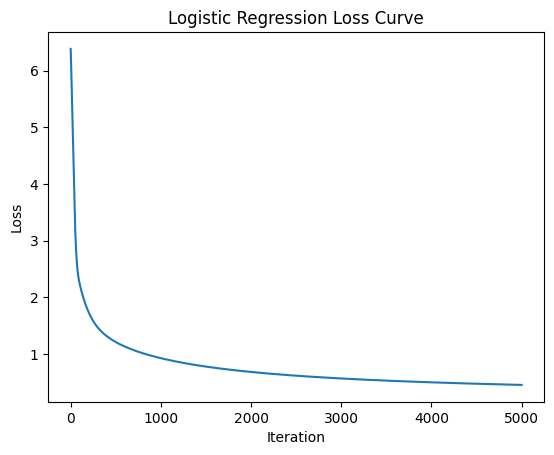

In [34]:
num_features = M_train_bow.shape[1]
weights = np.random.rand(num_features)
bias = np.random.rand(1)
n_iters = 5000
lr = 0.2
losses = []

# training loop
for i in range(n_iters):
    z = np.dot(M_train_bow, weights) + bias
    q = 1 / (1 + np.exp(-z))
    loss = -np.mean(y_train_sentiment * np.log(q + 1e-9) + (1 - y_train_sentiment) * np.log(1 - q + 1e-9))
    losses.append(loss)
    dw = np.dot(M_train_bow.T, (q - y_train_sentiment)) / len(y_train_sentiment)
    db = np.mean(q - y_train_sentiment)
    weights -= lr * dw
    bias -= lr * db

    if (i + 1) % 100 == 0:
        print(f"Iteration {i+1}/{n_iters}, Loss: {loss:.4f}")

import matplotlib.pyplot as plt
plt.plot(range(1, len(losses) + 1), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Logistic Regression Loss Curve")
plt.show()

In [35]:
# predictions
z = M_test_bow.dot(weights) + bias
q = 1 / (1 + np.exp(-z))

y_test_pred = [int(prob > 0.5) for prob in q]

y_test = y_test_sentiment

acc_test = [int(yp == y_test[s]) for s, yp in enumerate(y_test_pred)]
accuracy = sum(acc_test) / len(acc_test)

labels_test_pred = ["positive" if pred == 1 else "negative" for pred in y_test_pred]

true_positives = sum([int(yp == "positive" and y_test[s] == 1) for s, yp in enumerate(labels_test_pred)])
false_positives = sum([int(yp == "positive" and y_test[s] == 0) for s, yp in enumerate(labels_test_pred)])
false_negatives = sum([int(yp == "negative" and y_test[s] == 1) for s, yp in enumerate(labels_test_pred)])
true_negatives = sum([int(yp == "negative" and y_test[s] == 0) for s, yp in enumerate(labels_test_pred)])

# precision and recall
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

Accuracy: 0.7963
Precision: 0.8185
Recall: 0.8308


In [36]:
# analysing predictions
for i in range(10):
    review_index = test_indices[i]
    review = reviews[review_index]
    true_label = "positive" if y_test_sentiment[i] == 1 else "negative"
    predicted_label = "positive" if y_test_pred[i] == 1 else "negative"
    predicted_prob = q[i]

    print(f"Review: {review}")
    print(f"True Sentiment: {true_label}")
    print(f"Predicted Sentiment: {predicted_label} (Probability: {predicted_prob:.4f})")
    print()

Review: ok good cd im not suprised ok jaheim may not have the b best voice but his music is good and it goes will with the voice that he has  yes yall this album does use profanity but the songs actually have meanings i like that daddy thing song and like a dj this album looks at issues from a mans  point of view ya know weve heard the angry woman and how the man did t his and that now jaheim looks at it from a males view ok yall i know he is not the first one to do this but he did it well also this is a break from that  that is played on the radio
True Sentiment: positive
Predicted Sentiment: positive (Probability: 0.5198)

Review: weve had the same set with christmas colors for three years  after the first year the whistle unit housed in the tender no longer worked  and about 10 minutes into running the second year the engine stopped  found that the engine was wired so that the power wire was rubbing a drive wheelthe engine is built with an underpowered motor such that a fairly high 